In [3]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

In [5]:
input_path = '../Data'

feature_file = 'Mordred_Descriptors.csv'
# features_file_2 =  'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set.csv' 

training_task_file = 'TrainingData_mixturedist.csv'

# Dragon features
features = pd.read_csv(os.path.join(input_path, feature_file))
# features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))


# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))



In [4]:
# Print feature dimension:
print('Total # of molecules with Mordred Descriptors provided:', features.shape[0])
print('Mordred descriptor dimension:', features.shape[1])

Total # of molecules with Mordred Descriptors provided: 169
Mordred descriptor dimension: 1494


In [10]:
# Create df with rows matching the 'CID' values in 'features_CIDs'
new_features_df = features[features['Unnamed: 0'].isin(features_CIDs)]
print('Total number of CIDs in corrected mixture file found in the Mordred Descriptor df:', len(new_features_df))

Total number of CIDs in corrected mixture file found in the Mordred Descriptor df: 157


----

### Decided to use the Mordred package directly

In [112]:
import requests
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.impute import SimpleImputer

In [113]:
def get_smiles_from_cid(cid):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/txt"
    response = requests.get(url)
    
    if response.status_code == 200:
        smiles = response.text.strip()
        return smiles
    else:
        print(f"Failed to retrieve SMILES for CID {cid}. Status code: {response.status_code}")
        return None

In [114]:
cid = 2244  # Example CID 

smiles = get_smiles_from_cid(cid)

if smiles is not None:
    print(f"SMILES for CID {cid}: {smiles}")
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        print("Molecule created successfully from SMILES")
    else:
        print("Failed to create molecule from SMILES")
else:
    print("Failed to retrieve SMILES")

SMILES for CID 2244: CC(=O)OC1=CC=CC=C1C(=O)O
Molecule created successfully from SMILES


In [ ]:
smiles = []
for cid in features_CIDs:
    smiles.append(get_smiles_from_cid(cid))

In [ ]:
mols = []
for smile in smiles:
    mols.append(Chem.MolFromSmiles(smile))

In [ ]:
# create descriptor calculator with all descriptors
calc = Calculator(descriptors)

# pandas method calculate multiple molecules (return pandas DataFrame)
df = calc.pandas(mols)

100%|██████████| 162/162 [00:09<00:00, 17.57it/s]


In [116]:
features = df.drop(['ABC', 'ABCGG'], axis = 1)

In [117]:
features.index = features_CIDs

In [118]:
features = features.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

In [119]:
features = features.dropna(axis=1, how='all')

In [120]:
features.shape

(162, 1484)

In [121]:
# Identify columns with the same value across all rows (this has nothing to do with the CID troubleshooting)
columns_to_drop = []
for column in features.columns:
    if len(features[column].unique()) == 1:
        columns_to_drop.append(column)

print("Number of columns to be dropped:", len(columns_to_drop))

features = features.drop(columns=columns_to_drop)

# Print reduced shape:
print("Updated DataFrame shape:", features.shape)

Number of columns to be dropped: 202
Updated DataFrame shape: (162, 1282)


In [122]:
features.to_csv('../Data/Mordred_features_in-house.csv')

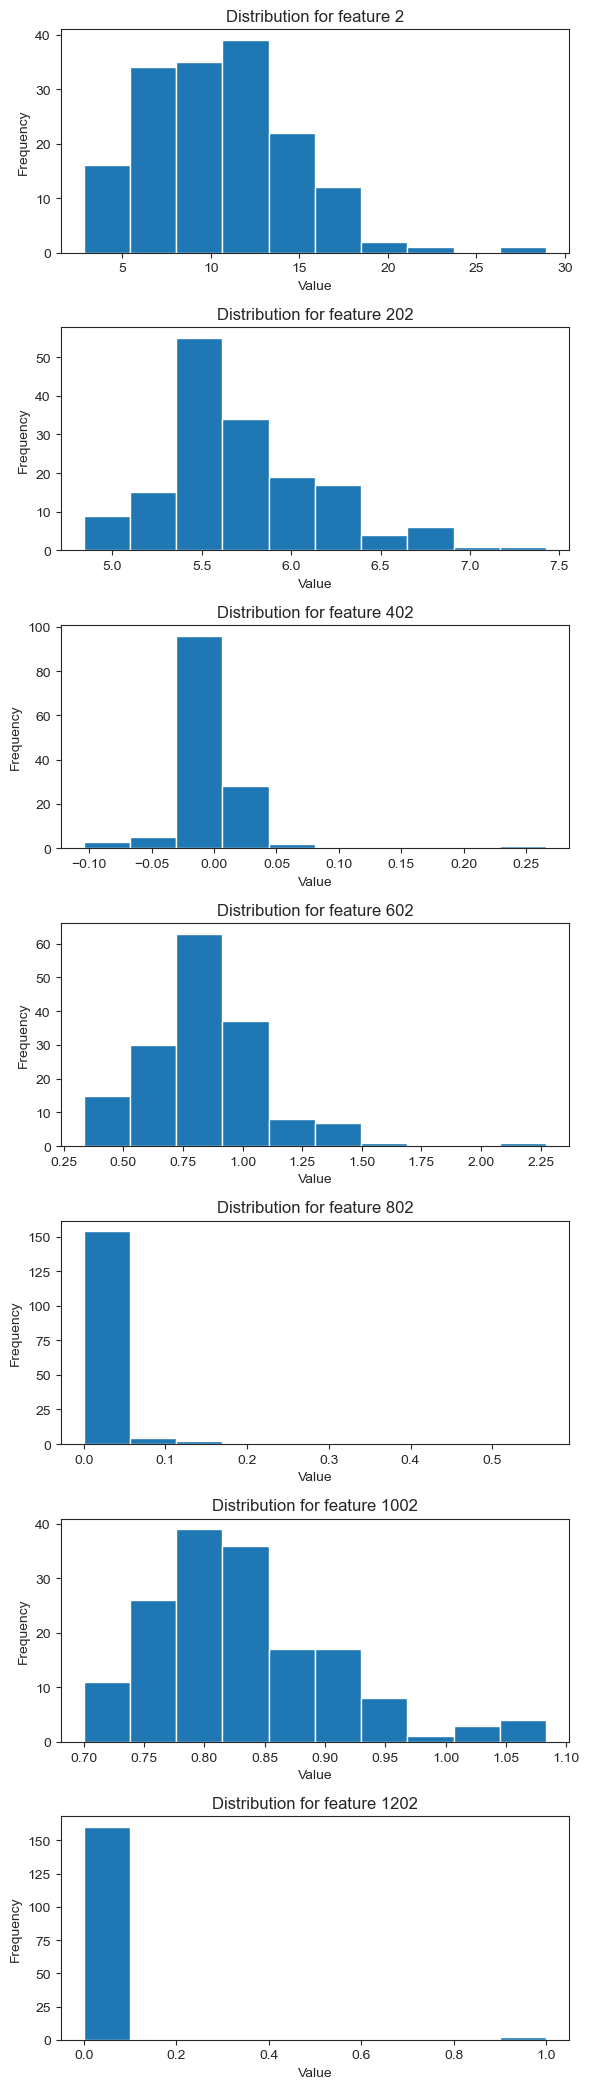

In [71]:
selected_n = list(range(2, 1300, 200))

# Create a figure and subplots
fig, axs = plt.subplots(len(selected_n), 1, figsize=(6, 3*len(selected_n)))

# Plot the distributions on separate subplots
for i, n in enumerate(selected_n):
    axs[i].hist(features.to_numpy()[:, n])
    axs[i].set_title(f"Distribution for feature {n}")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [123]:
scaler = StandardScaler(with_mean=True, with_std=True)
features = scaler.fit_transform(features)

In [124]:
# Convert DataFrame to a numpy array
features_array = features

# Create an imputer object with mean strategy
imputer = SimpleImputer(strategy='mean')
# Impute missing values
imputed_features = imputer.fit_transform(features_array)

## same effect here
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# imputed_features = imputer.fit_transform(features)

## some fancy way
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputed_features = imputer.fit_transform(features)


# Map CID to 96 dim features:
CID2features =  {CID: imputed_features[i] for i, CID in enumerate(features_CIDs)}

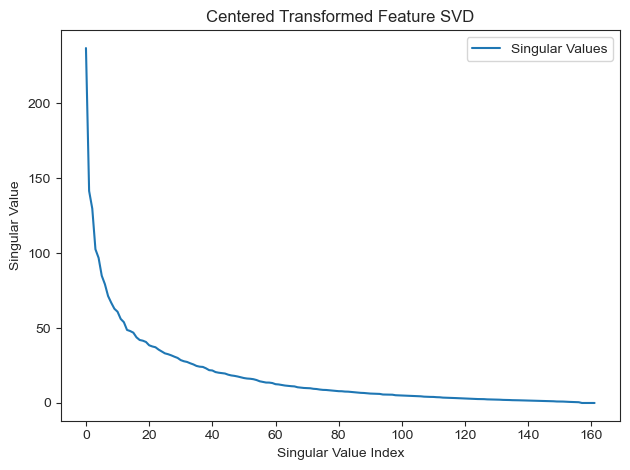

In [125]:
# Perform SVD on the imputed matrix
U, s, VT = np.linalg.svd(imputed_features)

# Plot singular values
plt.plot(s, label='Singular Values')

plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Centered Transformed Feature SVD')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

In [126]:
PR = np.sum(s)**2 / np.sum(s**2)
print(f'Participation ratio: {PR}')
print(f'k (dimensions that explains 86% variance) = {PR/2}')

Participation ratio: 46.12749535680609
k (dimensions that explains 86% variance) = 23.063747678403043


In [127]:
# Calculate the cumulative sum of squared singular values
cumulative_variance = np.cumsum(s**2) / np.sum(s**2)

# Choose a threshold for the desired amount of variance (e.g., 90%)
threshold = 0.90

# Find the smallest number of dimensions that exceed the threshold
effective_dimension = np.argmax(cumulative_variance >= threshold) + 1

print(f"Effective dimension for 90% variance: {effective_dimension}")

Effective dimension for 90% variance: 27


In [128]:
test_mixture_unmixed_embeddings, test_CIDs = get_individual_embedding(1, "Snitz 1", mixtures_IDs, CID2features)
print('Number of molecules in this mixture:', test_mixture_unmixed_embeddings.shape[0])
print('Dimension of embedding:',  test_mixture_unmixed_embeddings.shape[1])

Number of molecules in this mixture: 10
Dimension of embedding: 1282


In [129]:
num_nan = np.isnan(test_mixture_unmixed_embeddings).sum()
print(f"The array contains {num_nan} NaN values.")

The array contains 0 NaN values.


In [185]:
X, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features, method = 'avg')

In [186]:
num_nan = np.isnan(X[0][0]).sum()
print(f"The array contains {num_nan} NaN values.")

The array contains 0 NaN values.


In [187]:
# Convert the input pairs to a suitable format for training
X_pairs = np.array([(np.concatenate((x1, x2))) for x1, x2 in X])
y_true = np.array(y)

In [188]:
X_pair1 = X_pairs[:, :96] 
X_pair2 = X_pairs[:, 96:] 

 <span style="color:orange;">NOTE: Not sure yet how to get the distance similarity etc with NaN values; we have just imputated with mean </span>

In [189]:
distances = [get_euclidean_distance(m[0], m[1]) for m in X]
similarities = [get_cosine_similarity(m[0], m[1]) for m in X]
angles = [get_cosine_angle(m[0], m[1]) for m in X] 

### Correlation between combined mixture embeddings and eperimetal values

In [190]:
dist_corr = np.corrcoef(distances, y_true)[0, 1]
print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.3929441724971393


In [191]:
sim_corr = np.corrcoef(similarities, y_true)[0, 1]
print('R (Cosyne similarity v.s. Experimental Value): ', sim_corr)

R (Cosyne similarity v.s. Experimental Value):  -0.47231315349106934


In [192]:
angle_corr = np.corrcoef(angles, y_true)[0, 1]
print('R (Vector angle v.s. Experimental Value): ', angle_corr)

R (Vector angle v.s. Experimental Value):  0.48817081132163304


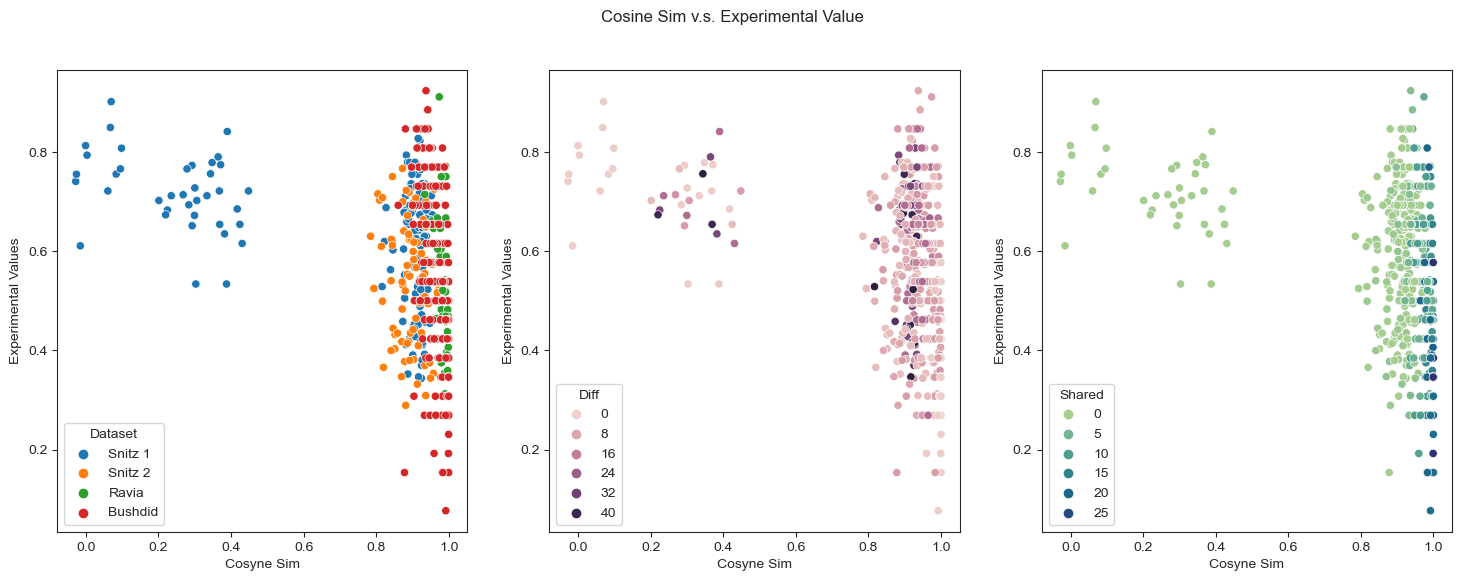

In [193]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Cosine Sim v.s. Experimental Value')
plt.show()

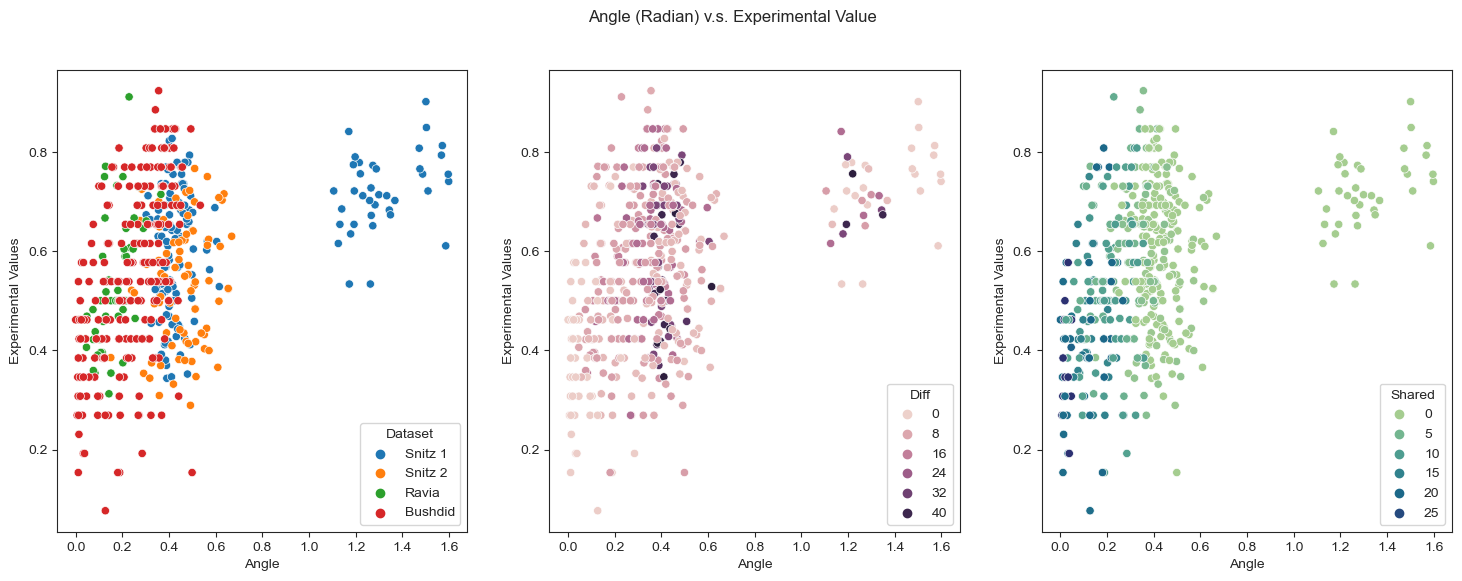

In [194]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x =  'Angle', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Angle', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Angle', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Angle (Radian) v.s. Experimental Value')

plt.show()

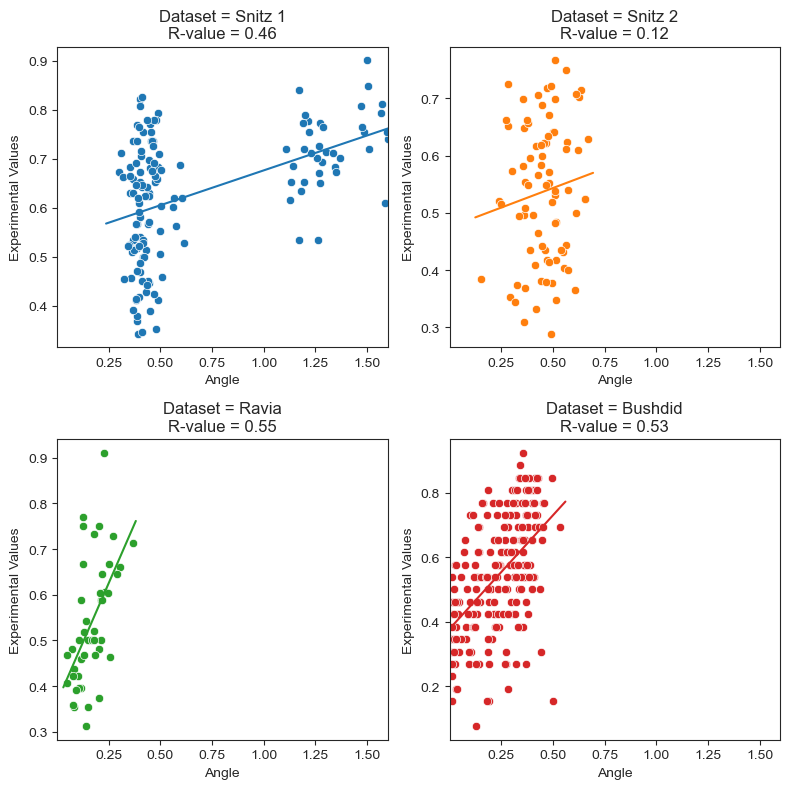

In [195]:
unique_values = training_set['Dataset'].unique()
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
color_palette = ['C0', 'C1', 'C2', 'C3']

min_angle = training_set['Angle'].min()
max_angle = training_set['Angle'].max()

for i, value in enumerate(unique_values):
    data_subset = training_set[training_set['Dataset'] == value]
    sns.scatterplot(data=data_subset, x='Angle', y='Experimental Values', ax=axs[i], color=color_palette[i])
    
    slope, intercept, r_value, _, _ = stats.linregress(data_subset['Angle'], data_subset['Experimental Values'])
    x_vals = np.array(axs[i].get_xlim()) 
    y_vals = intercept + slope * x_vals 
    axs[i].plot(x_vals, y_vals, color=color_palette[i])
    
    axs[i].set_xlim(min_angle, max_angle) 
    axs[i].set_title(f"Dataset = {value}\nR-value = {r_value:.2f}")

plt.tight_layout()
plt.show()

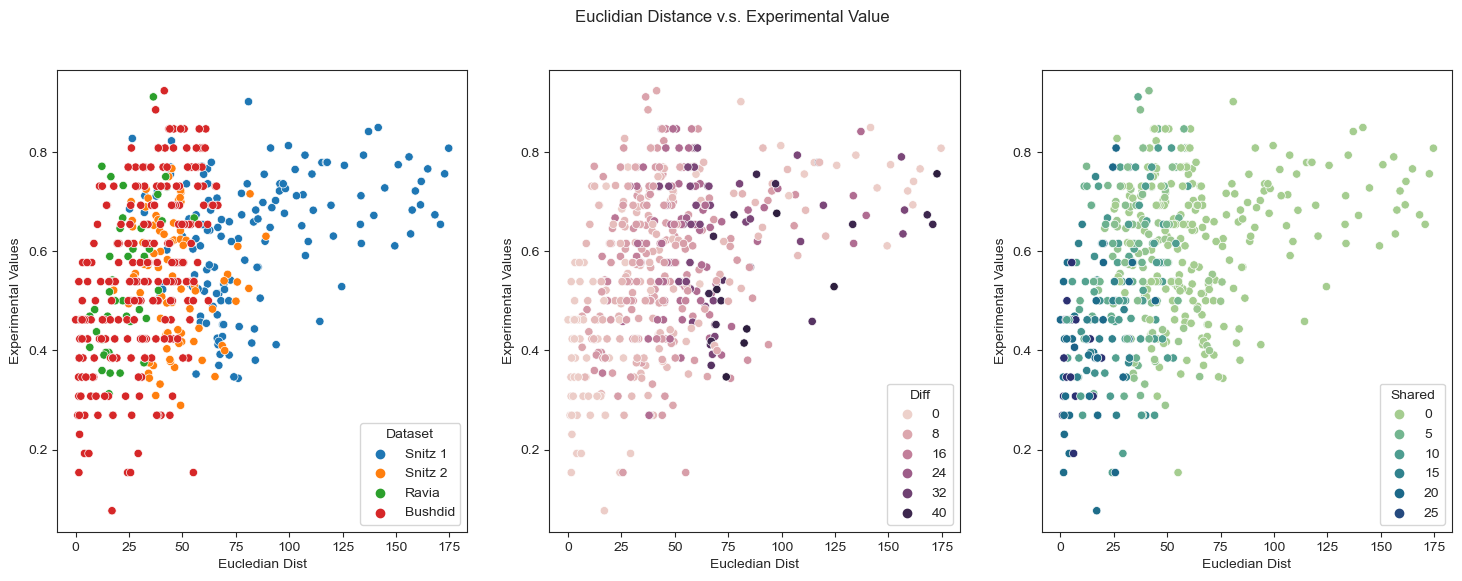

In [196]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x =  'Eucledian Dist', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Eucledian Dist', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Eucledian Dist', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Euclidian Distance v.s. Experimental Value')

plt.show()

In [197]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [198]:
training_set['Eucledian Dist'] = distances
training_set['Cosyne Sim'] = similarities
training_set['Angle'] = angles
training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]

In [199]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [200]:
### add all information above
X_features = np.hstack((X_pairs, np.array(distances).reshape(500, 1), 
                        np.array(similarities).reshape(500, 1), 
                        np.array(angles).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures), 
                        data_arr))

### First training:

In [201]:
n_folds = 10
seed = 314159

In [202]:
rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

In [208]:
# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

In [209]:
# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,Eucledian Dist,Cosyne Sim,Angle,Sum num monos,Shared,Diff,...,y_true_y,rf_pred_x,xgb_pred_x,y_true_x,rf_pred_y,xgb_pred_y,y_true_y,rf_pred,xgb_pred,y_true
360,Snitz 1,1,2,0.604167,12.632936,0.421606,1.135581,20,0,10,...,0.524038,0.586993,0.633181,0.769231,0.709553,0.778458,0.812500,0.603796,0.651063,0.625000
277,Snitz 1,1,3,0.651042,24.133968,0.082287,1.488417,11,0,10,...,0.610577,0.439146,0.372013,0.423077,0.614994,0.621316,0.692308,0.526718,0.488725,0.538462
109,Snitz 1,1,5,0.505208,11.841006,0.254048,1.313933,40,0,10,...,0.461538,0.579573,0.581069,0.524038,0.662688,0.662782,0.769231,0.709553,0.778458,0.812500
305,Snitz 1,1,6,0.411458,11.849881,0.238269,1.330213,50,0,10,...,0.846154,0.769156,0.770105,0.610577,0.433188,0.519894,0.423077,0.614994,0.621316,0.692308
190,Snitz 1,1,7,0.562500,21.331873,0.274845,1.292368,14,0,10,...,0.444452,0.454777,0.443309,0.307692,0.674986,0.599676,0.721154,0.627007,0.704046,0.769231


In [210]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.601
Random Forest - RMSE: 0.125

XGBoost - R: 0.536
XGBoost - RMSE: 0.134


#### Observations:

1. RF although in this example has a better score, tends to predict a safe value

2. prediction are correlated for the two methods, off ones are predicted off in the same way..

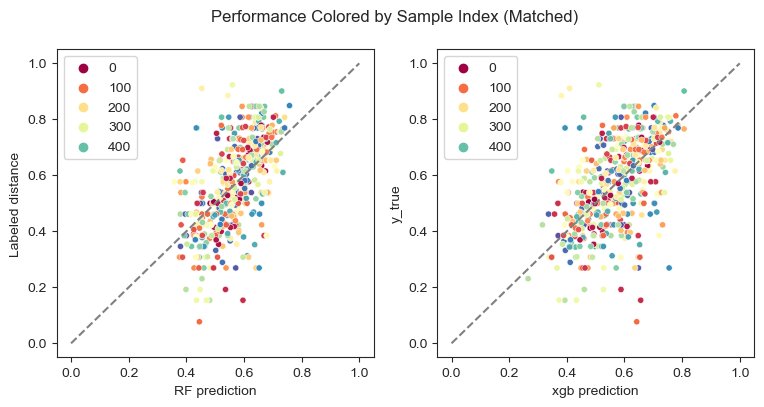

In [211]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()

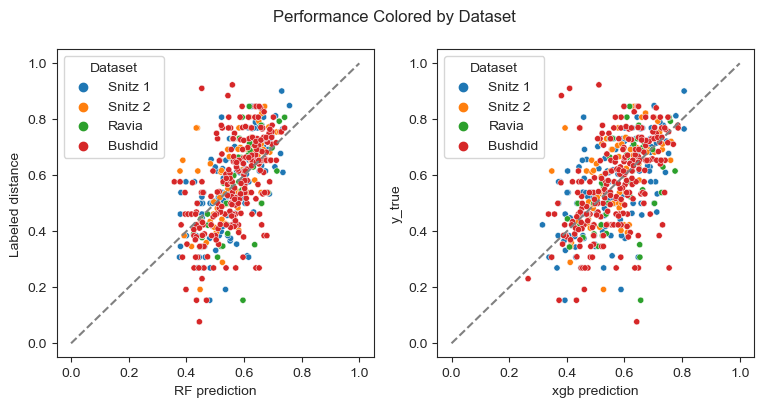

In [212]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Dataset', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Dataset', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Dataset')
plt.show()

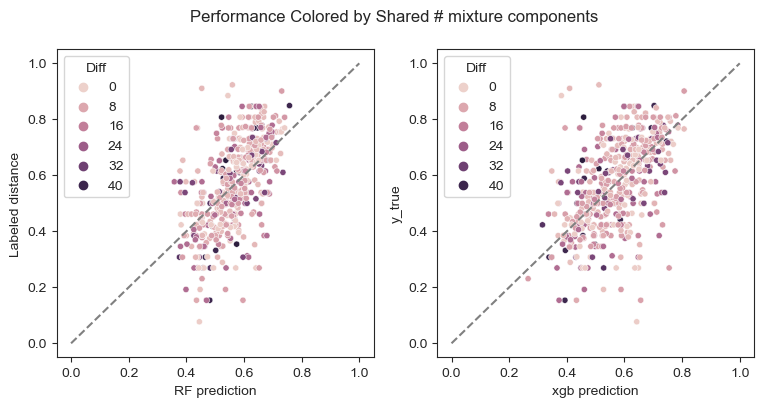

In [213]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Diff', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Diff', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Shared # mixture components')

plt.show()

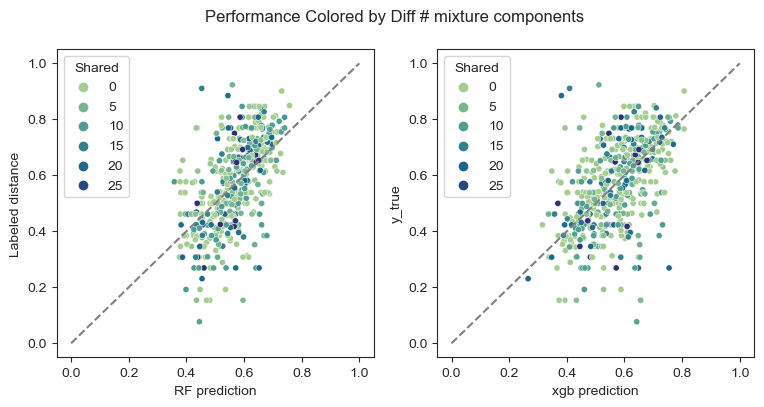

In [214]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Shared', ax = ax[0], s = 20, palette= 'crest')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Shared', ax = ax[1], s = 20, palette= 'crest')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Diff # mixture components')

plt.show()

In [215]:
training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(
    lambda x: abs(x['rf_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_15968/3348153056.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(


Dataset
Bushdid    0.103757
Ravia      0.095716
Snitz 1    0.091115
Snitz 2    0.091537
dtype: float64

In [216]:
training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(
    lambda x: abs(x['xgb_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_15968/2246081906.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(


Dataset
Bushdid    0.099816
Ravia      0.110287
Snitz 1    0.097261
Snitz 2    0.093381
dtype: float64